In [1]:
import numpy as np
import pandas as pd

import math
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

## Import Data

In [2]:
data = pd.read_csv('emails.csv')

In [3]:
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
text    5728 non-null object
spam    5728 non-null int64
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [7]:
df = data.copy()

## EDA

### Have a look at label distribution to check whether data is imbalanced

In [8]:
df.spam.value_counts()

0    4360
1    1368
Name: spam, dtype: int64

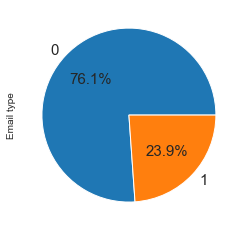

In [9]:
df.spam.value_counts().plot.pie(fontsize=15, autopct='%1.1f%%')
plt.ylabel('Email type')
plt.rcParams['font.size'] = 20

### Have a look at contents of spam and ham emails

In [21]:
df.text[df.spam == 1][0]

"Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image . convenience : logo and stationery  are provided in all formats ; easy - to - use content management system letsyou  change your website content and even its structure . promptness : you  will see logo drafts within three business days . affordability : your  ma

In [24]:
df.text[df.spam == 0][1368]

'Subject: hello guys ,  i \' m " bugging you " for your completed questionnaire and for a one - page  bio / statement on your thoughts on " business edu and the new economy " . if  my records are incorrect please re - ship your responses to me . i want to  put everything together next week so that i can ship it back to everyone .  the questionnaire is attached as well as copies of the bio pages for  michael froehls and myself ( two somewhat different approaches ) . the idea  of the latter is just to introduce yourself to the other panelists and give  them some background on how you are approaching the issues we will discuss .  we will also provide copies to the attendees and use this material for our  personal introductions at the opening of the panel discussions .  thanks and i look forward to seeing you in two weeks .  john  - waco _ background _ mf . doc  - jmartinbiosketch . doc  - questionnaire . doc  john d . martin  carr p . collins chair in finance  finance department  baylor u

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
import re

from wordcloud import WordCloud, STOPWORDS

In [16]:
def stem_tokenizer(text):
    stemmer = EnglishStemmer(ignore_stopwords=True)
    words = re.sub(r"[^A-Za-z0-9\-]", " ", text).lower().split()
    words = [stemmer.stem(word) for word in words]
    return words 

In [28]:
stem_tokenizer(df.text[0])

['subject',
 'natur',
 'irresist',
 'your',
 'corpor',
 'ident',
 'lt',
 'is',
 'realli',
 'hard',
 'to',
 'recollect',
 'a',
 'compani',
 'the',
 'market',
 'is',
 'full',
 'of',
 'suqgest',
 'and',
 'the',
 'inform',
 'isoverwhelminq',
 'but',
 'a',
 'good',
 'catchi',
 'logo',
 'stylish',
 'statloneri',
 'and',
 'outstand',
 'websit',
 'will',
 'make',
 'the',
 'task',
 'much',
 'easier',
 'we',
 'do',
 'not',
 'promis',
 'that',
 'havinq',
 'order',
 'a',
 'iogo',
 'your',
 'compani',
 'will',
 'automaticaili',
 'becom',
 'a',
 'world',
 'ieader',
 'it',
 'isguit',
 'ciear',
 'that',
 'without',
 'good',
 'product',
 'effect',
 'busi',
 'organ',
 'and',
 'practic',
 'aim',
 'it',
 'will',
 'be',
 'hotat',
 'nowaday',
 'market',
 'but',
 'we',
 'do',
 'promis',
 'that',
 'your',
 'market',
 'effort',
 'will',
 'becom',
 'much',
 'more',
 'effect',
 'here',
 'is',
 'the',
 'list',
 'of',
 'clear',
 'benefit',
 'creativ',
 'hand',
 '-',
 'made',
 'origin',
 'logo',
 'special',
 'done'

In [98]:
def word_cloud_plot(s, title):
    '''Parameter s: array 
                 title: string, the plot name
    Output wordcloud'''
    
    text = ''
    
    for value in s:
        words = stem_tokenizer(value)
#         print(index, words)
        words = " ".join(words)
        text = text + words + ' '
        
#     morestop = ['subject','one','will','us','need','ect','hou','kaminski','vinc']
    morestop = []
    morestop = morestop + list(STOPWORDS)
    
    wordcloud = WordCloud(#width = 600, height = 600, 
                    background_color ='white', 
                    stopwords = morestop, 
                    min_font_size = 10).generate(text) 

    # plot the WordCloud image                        
    plt.figure(figsize = (6, 6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.title(title)
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

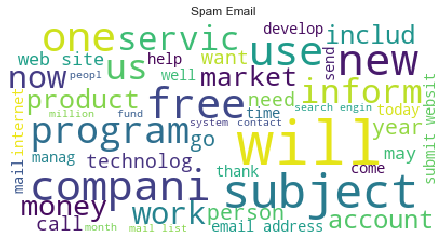

In [99]:
s = df.text[df.spam == 1].values
word_cloud_plot(s, 'Spam Email')

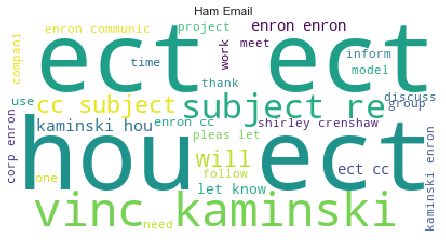

In [100]:
s = df.text[df.spam == 0].values
word_cloud_plot(s, 'Ham Email')

## Model implementation 

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [12]:
X = df["text"] # Note that it is a Series rather than a DataFrame here
y = df['spam']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Bernouli Naive Bayes

In [14]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

* __CountVector + BernoulliNB__

In [17]:
cv = CountVectorizer(stop_words=stopwords.words('english'),
                     tokenizer=stem_tokenizer,
                     lowercase=True,
                     max_df=0.5,
                     min_df=5,
                     ngram_range=(1, 3),
                     binary=True
                    )

In [18]:
tfidf_transformer = TfidfTransformer()

In [19]:
nbclassifier = Pipeline([('cv', cv), ('nb', BernoulliNB())])

In [20]:
nbclassifier = nbclassifier.fit(X_train, y_train)

In [21]:
print(classification_report(y_test, nbclassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1314
           1       0.90      0.99      0.94       405

    accuracy                           0.97      1719
   macro avg       0.95      0.98      0.96      1719
weighted avg       0.97      0.97      0.97      1719



In [22]:
from sklearn.metrics import roc_curve,roc_auc_score

In [24]:
y_test_proba = nbclassifier.predict_proba(X_test)
y_test_proba

array([[1.00000000e+000, 6.10118357e-173],
       [1.00000000e+000, 4.91093332e-036],
       [3.04816398e-168, 1.00000000e+000],
       ...,
       [1.00000000e+000, 1.43071496e-075],
       [1.00000000e+000, 3.63511293e-022],
       [1.00000000e+000, 3.99144303e-032]])

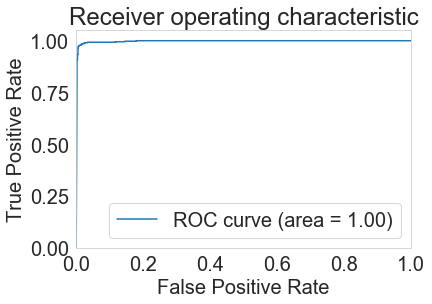

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
plt.plot(fpr, tpr, label='ROC curve (area = {0:.2f})'.format(roc_auc_score(y_test, y_test_proba[:,1])))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.grid()
plt.legend(loc="lower right")

* TFIDF + BernoulliNB

In [101]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'),
                        tokenizer=stem_tokenizer,
                        lowercase=True,
                        max_df=0.8,
                        min_df=5,
                        ngram_range=(1, 3)
                       )

In [102]:
nbclassifier = Pipeline([('tfidf', tfidf), ('nb', BernoulliNB())])

In [103]:
nbclassifier = nbclassifier.fit(X_train, y_train)

In [104]:
print(classification_report(y_test, nbclassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1314
           1       0.90      0.99      0.94       405

    accuracy                           0.97      1719
   macro avg       0.95      0.98      0.96      1719
weighted avg       0.97      0.97      0.97      1719



In [ ]:
grams = [''] * len(nbclassifier['tfidf'].vocabulary_)
for k, v in nbclassifier['tfidf'].vocabulary_.items():
    grams[v] = k
    print(v,k,grams[v])

In [106]:
pos_weight = list(zip(grams, nbclassifier['nb'].feature_log_prob_[0]))
pos_weight.sort(key=lambda x: x[1])
pos_weight[-5:]

[('thank', -0.6240668238360714),
 ('pleas', -0.5606005245979615),
 ('enron', -0.522264375854415),
 ('vinc', -0.44358406621177426),
 ('-', -0.20220292734778322)]

In [107]:
neg_weight = list(zip(grams, nbclassifier['nb'].feature_log_prob_[1]))
neg_weight.sort(key=lambda x: x[1])
neg_weight[-5:]

[('one', -1.270009280459285),
 ('mail', -1.2517272356218365),
 ('http', -1.2337734320052407),
 ('com', -1.055016941375782),
 ('-', -0.31393029852671717)]

### LSTM

In [58]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
# fix random seed for reproducibility
np.random.seed(0)

In [55]:
def clean_text(text):
    '''clean text: keep alphabets, convert to low case
       Parameter: text in one column '''
    stemmer = EnglishStemmer(ignore_stopwords=True)
    words = re.sub(r"[^A-Za-z0-9\-]", " ", text).lower().split()
    words = [stemmer.stem(word) for word in words]
    words = ' '.join(words)
    return words

In [56]:
X = df.text.map(clean_text).values

In [52]:
type(X)

numpy.ndarray

In [63]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=False)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 29367 unique tokens.


In [64]:
X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5728, 250)


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [80]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 5,080,501
Trainable params: 5,080,501
Non-trainable params: 0
_________________________________________________________________
None


In [81]:
model.fit(X_train, y_train, epochs=3, batch_size=64)

Epoch 1/3
4009/4009 [==============================] - 42s 10ms/step - loss: 0.3627 - accuracy: 0.8371
Epoch 2/3
4009/4009 [==============================] - 43s 11ms/step - loss: 0.0561 - accuracy: 0.9843
Epoch 3/3
4009/4009 [==============================] - 43s 11ms/step - loss: 0.0284 - accuracy: 0.9928


In [82]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: {:.2f}%".format(scores[1]*100))

Accuracy: 98.60%
